# Steinschlagrisiko cwm1

## Aufgabenstellung
Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4  ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.


## Grundlagen
Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. Diese Daten können von Ihnen zur Modellbildung verwendet werden und stehen unter folgenden Links zur Verfügung:

Ereignis aus Ablösungszone 1: https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0

Ereignis aus Ablösungszone 2: https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0

NB: Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise. Die Masse ist eine Experten-Schätzung des Geologen.
Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## Abgabe
Form der Abgabe
Quellcode der Berechnungen in einem Notebook (R oder Jupyter).

Kurzer Bericht (max 8 Seiten) der die Berechnungen klar und nachvollziebar beschreibt und die Empfehlung an den Kantonsingenieur begründet.

### Abgabetermin
Montag, 10. Januar 2022

## 1. Bibliotheken Importieren

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

## 2. Vorbereitung der Daten
### 2.1 Daten einlesen und reinigen

In [21]:
# Daten laden
df1 = pd.read_csv("out_1.csv")
df2 = pd.read_csv("out_2.csv")

# Spaltennamen von df2 ändern so dass sie die Spaltennamen von df1 entsprechen
df2 = df2.rename(columns={"Date":"Datum","m [kg]":"Masse [kg]","v [m/s]":"Geschwindigkeit [m/s]"})

# Datentabelle auswählen
df1 = df1.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]
df2 = df2.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]

# Spalte Ablösungszone hinzufügen
df1['Ablösungszone'] = 1
df2['Ablösungszone'] = 2

# Zeilen mit NA Werte löschen
df1 = df1.dropna()
df2 = df2.dropna()

Datum und Uhrzeit in einer Spalte zusammenfügen damit daraus einen Datetime Objekt erstellt werden kann.

In [22]:
df1["Datum"] = pd.to_datetime(df1["Datum"] + " " + df1["Uhrzeit"])
df2["Datum"] = pd.to_datetime(df2["Datum"] + " " + df2["Uhrzeit"])

df1 = df1.drop("Uhrzeit", axis=1)
df2 = df2.drop("Uhrzeit", axis=1)

In [23]:
df1

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
63,2019-03-18 16:00:00,167.0,8.9,1
64,2019-03-22 18:00:00,2847.0,7.0,1
65,2019-03-26 00:00:00,44.0,8.9,1
66,2019-03-26 06:00:00,45.0,8.4,1


In [24]:
df2

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,38.0,45.4,2
1,2019-01-03 06:00:00,187.0,41.6,2
2,2019-01-04 10:00:00,36.0,44.6,2
3,2019-01-07 14:00:00,6.0,41.2,2
4,2019-01-11 06:00:00,65.0,39.6,2
5,2019-01-11 16:00:00,58.0,33.2,2
6,2019-01-14 11:00:00,365.0,40.2,2
7,2019-01-16 02:00:00,22.0,46.5,2
8,2019-01-18 06:00:00,146.0,36.2,2
9,2019-01-19 17:00:00,29.0,38.3,2


### 2.2 Tabellen zusammenfügen

In [25]:
df3 = pd.concat([df1, df2], ignore_index=True)
df3

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
95,2019-03-20 10:00:00,16.0,42.1,2
96,2019-03-21 13:00:00,211.0,29.0,2
97,2019-03-24 16:00:00,3.0,42.3,2
98,2019-03-25 14:00:00,63.0,43.2,2


## 3. Herausfinden von benötigten Daten

### 3.1 Kinetische Energie
Hier wird die kinetische Energie von jedem Steinschlag berechnet und zu einer Liste hinzugefügt. Danach wird diese Liste als Spalte in df3 ergänzt.

In [26]:
list_mass = [(x) for x in df3["Masse [kg]"]]
list_speed = [(x) for x in df3["Geschwindigkeit [m/s]"]]
list_energy = [] 

for i in range(len(list_mass)):
    energy_kj = 0.5 * list_mass[i] * list_speed[i]**2 / 1000
    energy_kj = round(energy_kj,1)
    list_energy.append(energy_kj)

df3["Energie [kJ]"] = list_energy

In [27]:
df3["Energie [kJ]"]

0       6.8
1       8.7
2     131.4
3       7.3
4      18.5
      ...  
95     14.2
96     88.7
97      2.7
98     58.8
99     40.1
Name: Energie [kJ], Length: 100, dtype: float64

### 3.2 Durchschnitt der Massen berechnen

In der Ablösungszone 2 gibt es einen Steinschlag, der eine Masse von 0 hat. (index 23)

Die Masse darf nicht 0 sein, darum setzen wir für diese Masse den Mittelwert der Massen aus Ablösungszone 2 ein.

In [28]:
# Summe / Anzahl Werte - i, da der 0-Wert nicht berücksichtigt wird
def calcAverage(l, i):
    return round(sum(l) / float(len(l)-i),1)

In [15]:
list_mass_zone2 = df2["Masse [kg]"]

average = calcAverage(list_mass_zone2, 1)

# 0-Wert mit Durchschnitt ersetzen
for i in range(len(list_mass_zone2)):
    if list_mass_zone2[i] <= 0:
        list_mass_zone2[i] = average

### 3.3 Zeitbstand von Steinschlägen berechnen
Wir berechnen jetzt die Zeitabstände in Stunden von den Steinschlägen damit wir eine Normalverteilung aufstellen können.

In [16]:
def calcTimeDistance(zone):
    time_distances = []
    for i in range(len(zone)):
        try: 
            distance = int(abs(zone[i] - zone[i+1]).total_seconds() / 3600)
            time_distances.append(distance)
        except Exception:
            pass 
        
    return time_distances

In [17]:
# Create lists with times
dates_zone1 = list(i for i in df1["Datum"])
dates_zone2 = list(i for i in df2["Datum"])
    
time_dist_zone1 = calcTimeDistance(dates_zone1)
time_dist_zone2 = calcTimeDistance(dates_zone2)

avg_time_dist_zone1 = calcAverage(time_dist_zone1, 0)
avg_time_dist_zone2 = calcAverage(time_dist_zone2, 0)

print("Durchschnittlicher Zeitabstand von Steinschlägen in Stunden:")
print("Ablösungszone 1: {}".format(avg_time_dist_zone1))
print("Ablösungszone 2: {}".format(avg_time_dist_zone2))

Durchschnittlicher Zeitabstand von Steinschlägen in Stunden:
Ablösungszone 1: 30.6
Ablösungszone 2: 66.3


### 3.3 Normalverteilung der Zeit

In [24]:
def normDistribution(data):
    # Fit a normal distribution to the data:
    mu, std = stats.norm.fit(data)

    # Plot the histogram.
    plt.hist(data, bins=100, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

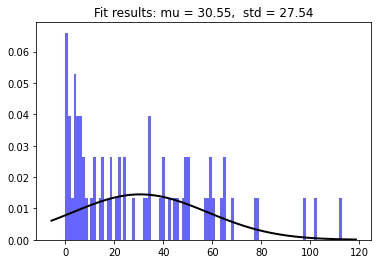

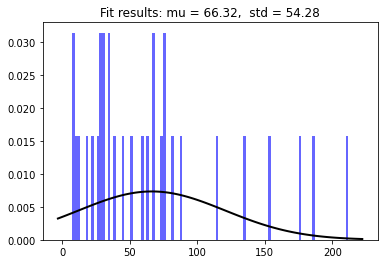

In [25]:
normDistribution(time_dist_zone1)
normDistribution(time_dist_zone2)

## 4 Wahrscheinlichkeitsverteilung der Masse und Geschwindigkeit

## Wahrscheinlichkeitsverteilung der Masse

,sumsquare_error,aic,bic,kl_div
genhyperbolic,0.000015,1811.773150,-1021.658707,inf
alpha,0.000015,1799.342465,-1027.774622,inf
expon,0.000019,1790.287904,-1019.387389,inf
gamma,0.000021,1765.999570,-1005.105427,inf
norm,0.000028,1843.326893,-990.168909,inf


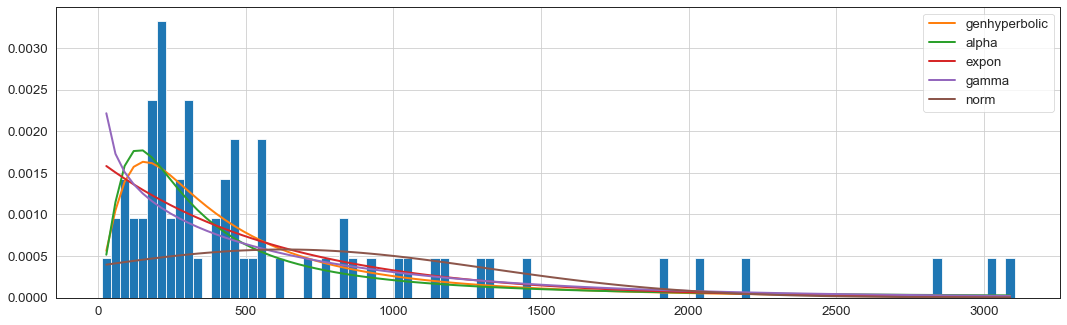

In [15]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=df1, x = "Masse [kg]", kind = "hist", bins = 150, aspect = 3.0)
masse_df1 = df1["Masse [kg]"].values
f_masse1 = Fitter(masse_df1,
           distributions=['alpha',
                          'beta',
                          "gamma",
                          "norm",
                          "expon",
                          "lognorm",
                          "chi2",
                          "genhyperbolic"])
f_masse1.fit()
f_masse1.summary()

,sumsquare_error,aic,bic,kl_div
genhyperbolic,0.001736,1336.607771,-296.966992,inf
expon,0.001742,1329.153311,-307.262105,inf
gamma,0.001770,1332.703887,-303.284140,inf
beta,0.001853,1277.519942,-298.344055,inf
chi2,0.001969,1366.709369,-299.872369,inf


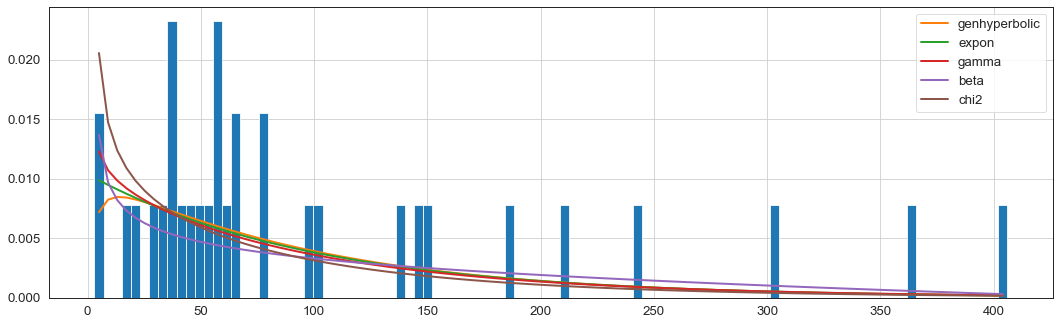

In [16]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=df2, x = "Masse [kg]", kind = "hist", bins = 150, aspect = 3.0)
masse_df2 = df2["Masse [kg]"].values
f_masse2 = Fitter(masse_df2,
           distributions=['alpha',
                          'beta',
                          "gamma",
                          "norm",
                          "expon",
                          "lognorm",
                          "chi2",
                          "genhyperbolic"])
f_masse2.fit()
f_masse2.summary()

,sumsquare_error,aic,bic,kl_div
genhyperbolic,0.000010,1858.164978,-1584.777492,inf
lognorm,0.000011,1871.031191,-1589.481725,inf
beta,0.000013,1871.677340,-1566.584984,inf
expon,0.000014,1905.824265,-1571.548089,inf
gamma,0.000014,1848.888118,-1565.826540,inf


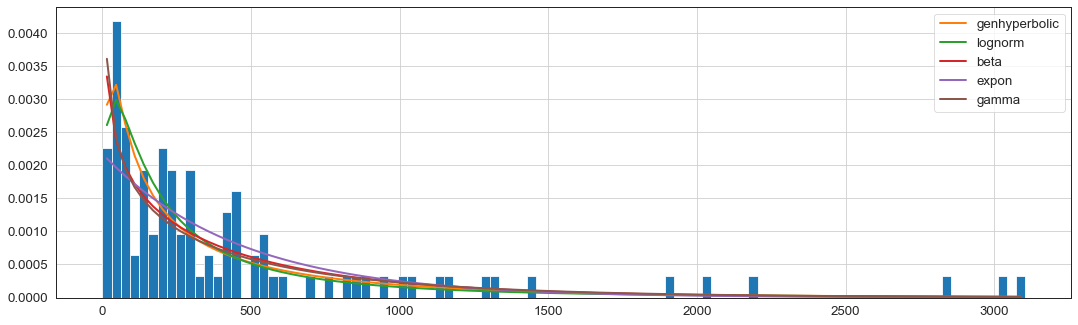

In [17]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=df3, x = "Masse [kg]", kind = "hist", bins = 150, aspect = 3.0)
masse_df3 = df3["Masse [kg]"].values
f_masse3 = Fitter(masse_df3,
           distributions=['alpha',
                          'beta',
                          "gamma",
                          "norm",
                          "expon",
                          "lognorm",
                          "chi2",
                          "genhyperbolic"])
f_masse3.fit()
f_masse3.summary()

## Wahrscheinlichkeitsverteilung der Geschwindigkeit

,sumsquare_error,aic,bic,kl_div
beta,1.004783,564.941843,-269.724003,inf
norm,1.007418,559.582300,-277.984954,inf
lognorm,1.008072,561.995251,-273.721325,inf
gamma,1.010142,560.352868,-273.581846,inf
chi2,1.017687,556.853850,-273.075810,inf


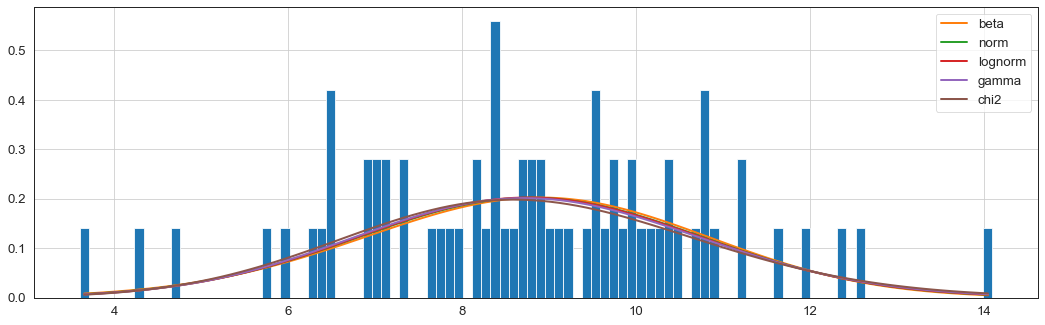

In [18]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=df1, x = "Geschwindigkeit [m/s]", kind = "hist", bins = 150, aspect = 3.0)
geschwindigkeit_df1 = df1["Geschwindigkeit [m/s]"].values
f_geschwindigkeit1 = Fitter(geschwindigkeit_df1,
           distributions=['alpha',
                          'beta',
                          "gamma",
                          "norm",
                          "expon",
                          "lognorm",
                          "chi2",
                          "genhyperbolic"])
f_geschwindigkeit1.fit()
f_geschwindigkeit1.summary()

,sumsquare_error,aic,bic,kl_div
beta,0.590531,648.128803,-113.896088,inf
norm,0.607154,675.068739,-119.939229,inf
lognorm,0.607632,677.569675,-116.448292,inf
chi2,0.608647,677.413072,-116.394853,inf
gamma,0.608798,677.225194,-116.386964,inf


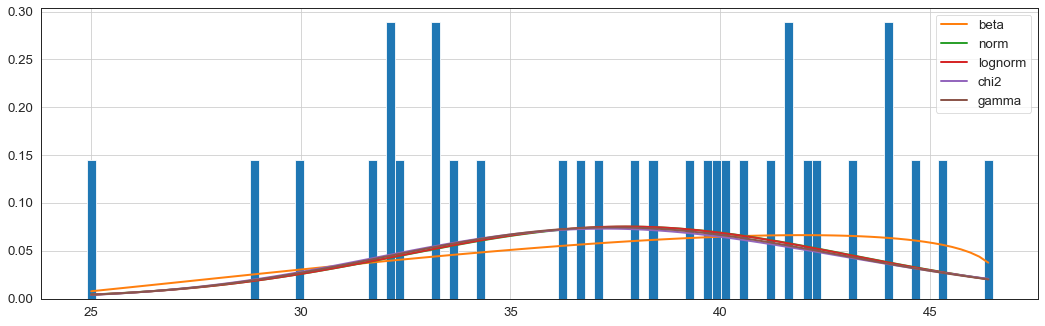

In [19]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=df2, x = "Geschwindigkeit [m/s]", kind = "hist", bins = 150, aspect = 3.0)
geschwindigkeit_df2 = df2["Geschwindigkeit [m/s]"].values
f_geschwindigkeit2 = Fitter(geschwindigkeit_df2,
           distributions=['alpha',
                          'beta',
                          "gamma",
                          "norm",
                          "expon",
                          "lognorm",
                          "chi2",
                          "genhyperbolic"])
f_geschwindigkeit2.fit()
f_geschwindigkeit2.summary()

,sumsquare_error,aic,bic,kl_div
alpha,0.075436,905.641671,-705.148940,inf
lognorm,0.092772,864.113830,-684.462270,inf
gamma,0.112229,834.472213,-665.423017,inf
chi2,0.112229,834.471821,-665.422976,inf
expon,0.114088,834.897643,-668.385322,inf


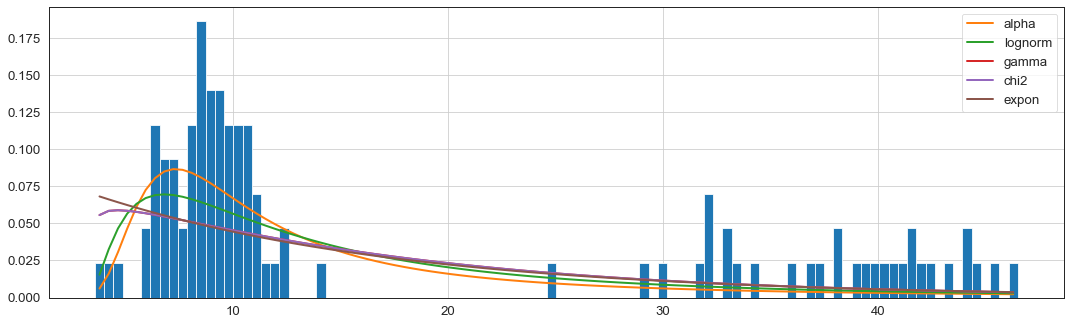

In [20]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=df3, x = "Geschwindigkeit [m/s]", kind = "hist", bins = 150, aspect = 3.0)
geschwindigkeit_df3 = df3["Geschwindigkeit [m/s]"].values
f_geschwindigkeit3 = Fitter(geschwindigkeit_df3,
           distributions=['alpha',
                          'beta',
                          "gamma",
                          "norm",
                          "expon",
                          "lognorm",
                          "chi2",
                          "genhyperbolic"])
f_geschwindigkeit3.fit()
f_geschwindigkeit3.summary()

In [21]:
get_distributions()

['alpha',
 'anglit',
 'arcsine',
 'argus',
 'beta',
 'betaprime',
 'bradford',
 'burr',
 'burr12',
 'cauchy',
 'chi',
 'chi2',
 'cosine',
 'crystalball',
 'dgamma',
 'dweibull',
 'erlang',
 'expon',
 'exponnorm',
 'exponpow',
 'exponweib',
 'f',
 'fatiguelife',
 'fisk',
 'foldcauchy',
 'foldnorm',
 'gamma',
 'gausshyper',
 'genexpon',
 'genextreme',
 'gengamma',
 'genhalflogistic',
 'genhyperbolic',
 'geninvgauss',
 'genlogistic',
 'gennorm',
 'genpareto',
 'gilbrat',
 'gompertz',
 'gumbel_l',
 'gumbel_r',
 'halfcauchy',
 'halfgennorm',
 'halflogistic',
 'halfnorm',
 'hypsecant',
 'invgamma',
 'invgauss',
 'invweibull',
 'johnsonsb',
 'johnsonsu',
 'kappa3',
 'kappa4',
 'ksone',
 'kstwo',
 'kstwobign',
 'laplace',
 'laplace_asymmetric',
 'levy',
 'levy_l',
 'levy_stable',
 'loggamma',
 'logistic',
 'loglaplace',
 'lognorm',
 'loguniform',
 'lomax',
 'maxwell',
 'mielke',
 'moyal',
 'nakagami',
 'ncf',
 'nct',
 'ncx2',
 'norm',
 'norminvgauss',
 'pareto',
 'pearson3',
 'powerlaw',
 'pow

## 6. Statistik

In [ ]:
df3.describe(include=['object'])

In [35]:
df3.describe(include='all')

<ipython-input-35-bb9d08cd69bc>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df3.describe(include='all')


,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone,Energie [kJ]
count,100,100.000000,100.00000,100.000000,100.000000
unique,97,NaN,NaN,NaN,NaN
top,2019-02-08 12:00:00,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
first,2019-01-01 09:00:00,NaN,NaN,NaN,NaN
last,2019-03-28 01:00:00,NaN,NaN,NaN,NaN
mean,NaN,459.230000,18.06900,1.320000,40.044000
std,NaN,626.671742,14.02409,0.468826,60.220709
min,NaN,0.000000,3.60000,1.000000,0.000000
25%,NaN,76.750000,8.37500,1.000000,9.375000


In [36]:
df3.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone,Energie [kJ]
count,100.000000,100.00000,100.000000,100.000000
mean,459.230000,18.06900,1.320000,40.044000
std,626.671742,14.02409,0.468826,60.220709
min,0.000000,3.60000,1.000000,0.000000
25%,76.750000,8.37500,1.000000,9.375000
50%,232.000000,10.05000,1.000000,18.900000
75%,509.750000,32.52500,2.000000,46.875000
max,3104.000000,46.50000,2.000000,394.800000


### Statistik von der Masse

In [37]:
varianz = df3["Masse [kg]"].var()
standardabweichung = df3["Masse [kg]"].std()
schiefemasse = df3["Masse [kg]"].skew()
kurtosis = df3["Masse [kg]"].kurtosis()
print(("Varianz {0}, Standardabweichung {1}, Schiefemasse {2}, Kurtosis {3}").format(varianz, standardabweichung, schiefemasse, kurtosis))

Varianz 392717.4718181818, Standardabweichung 626.6717416783541, Schiefemasse 2.612662741124922, Kurtosis 7.2808001103153615


## 6. Histogramme

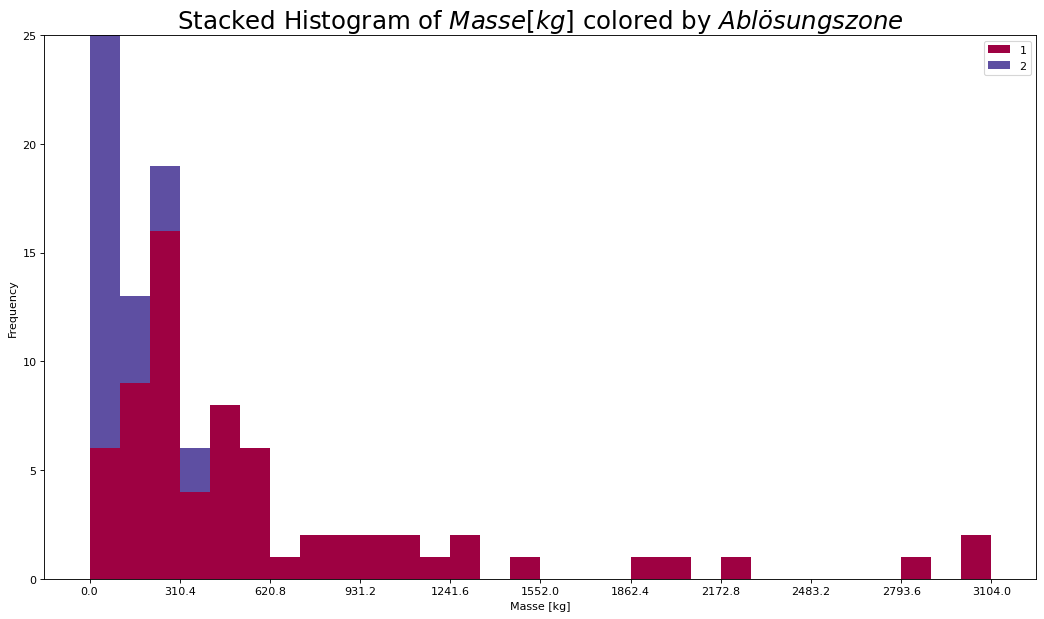

In [38]:
# Prepare data
x_var = 'Masse [kg]'
groupby_var = 'Ablösungszone'
df_agg = df3.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df3[x_var].values.tolist() for i, df3 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df3[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 25)
plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

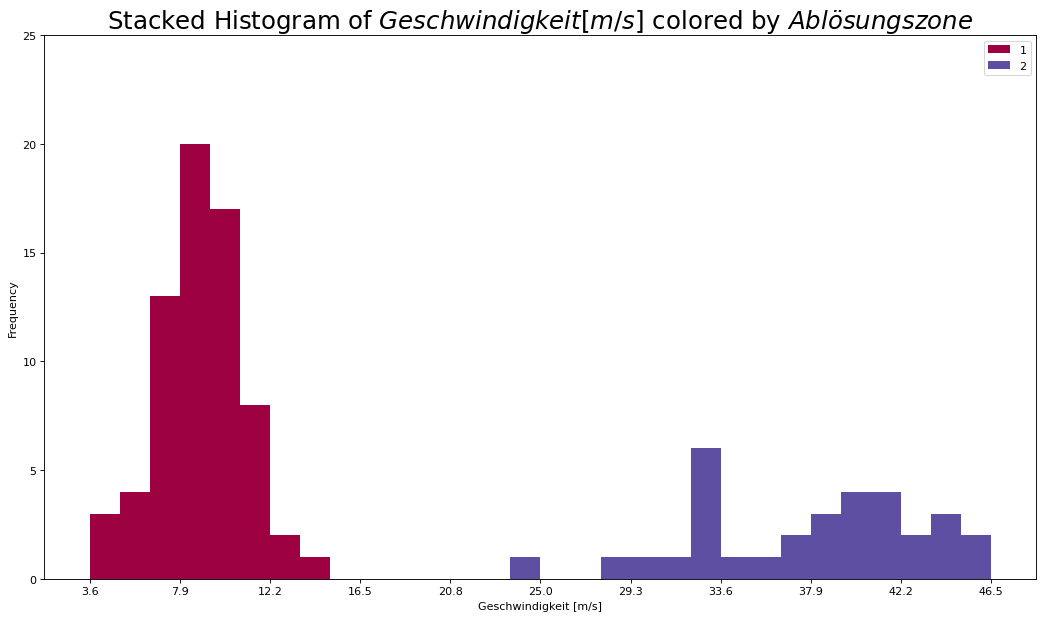

In [39]:
# Prepare data
x_var = 'Geschwindigkeit [m/s]'
groupby_var = 'Ablösungszone'
df_agg = df3.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df3[x_var].values.tolist() for i, df3 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df3[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 25)
plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

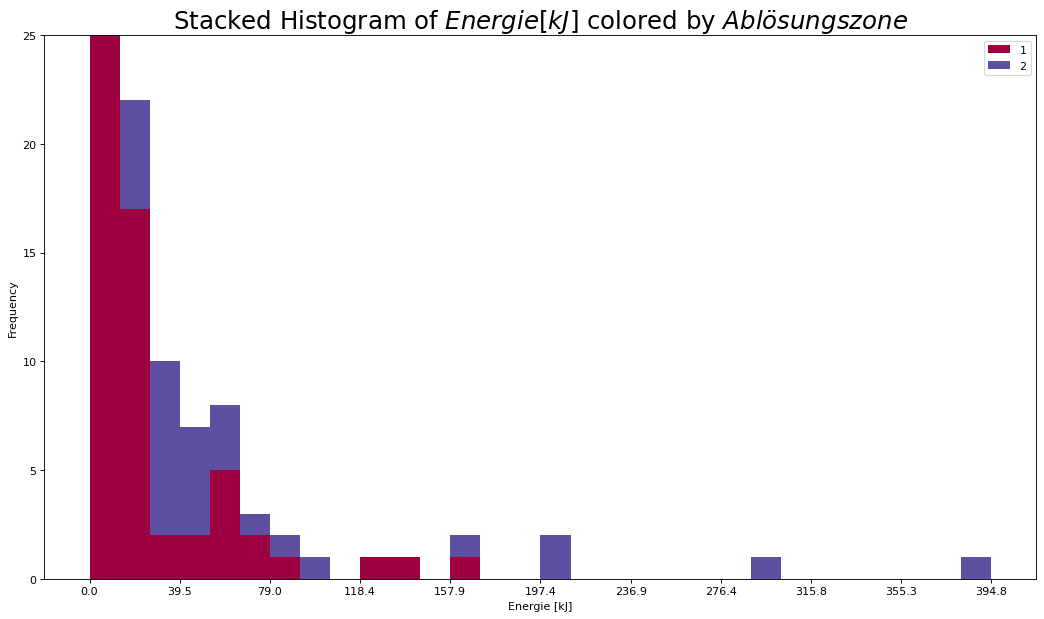

In [40]:
# Prepare data
x_var = 'Energie [kJ]'
groupby_var = 'Ablösungszone'
df_agg = df3.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df3[x_var].values.tolist() for i, df3 in df_agg]

# Draw
plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df3[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.ylim(0, 25)
plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
plt.show()

## 7. Streuediagramme

#### Scatterplot von Geschwindigkeit vs Masse

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


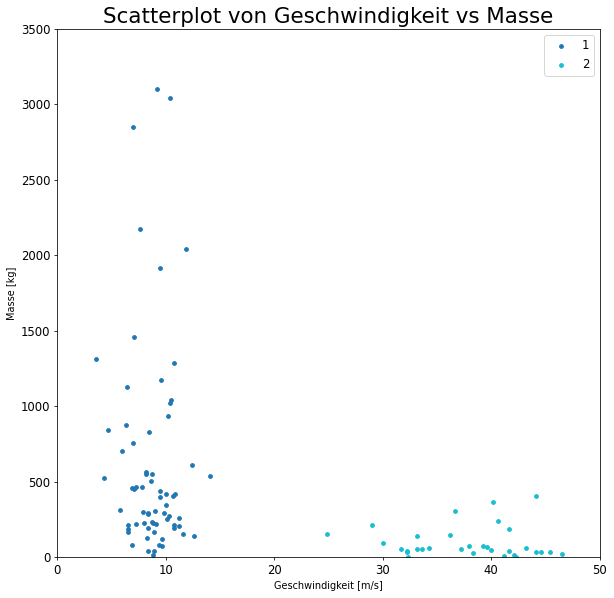

In [41]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 3500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### Scatterplot von Geschwindigkeit vs Energie

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


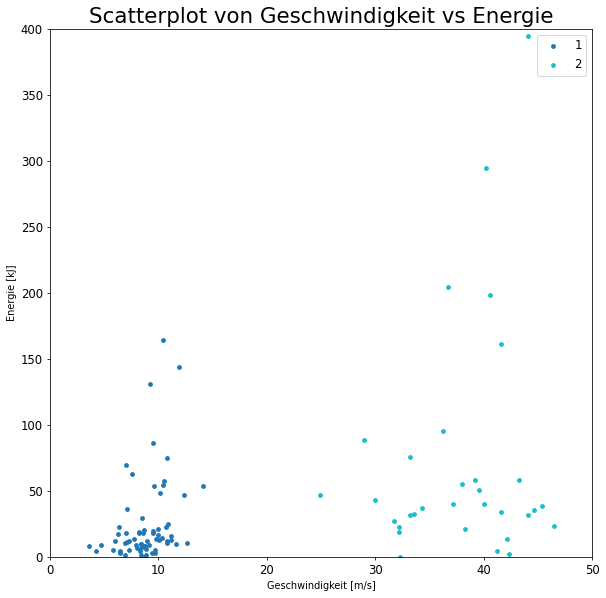

In [42]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Energie [kJ]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 400), xlabel='Geschwindigkeit [m/s]', ylabel='Energie [kJ]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Energie", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### Scatterplot von Energie vs Masse

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


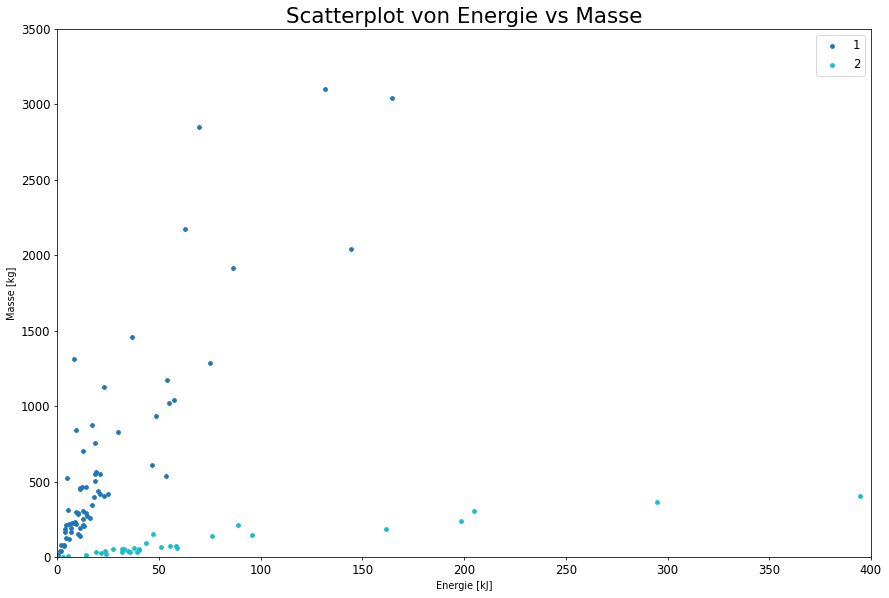

In [43]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(15, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Energie [kJ]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 400), ylim=(0, 3500), xlabel='Energie [kJ]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Energie vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

## 8. Time Plot
https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
Chart 35.

In [44]:
# Durchschnittliche Anzahl Steinschläge pro Stunde darstellen
def timelist():
    
    time_list = []
    
    for i in df3["Uhrzeit"]:
        time_list.append(i)
        
    time_list.sort()
                
    return {i: time_list.count(i) for i in time_list}

rockfalls = []
times = []

for t, r in timelist().items():
    times.append(t)
    rockfalls.append(r)

KeyError: 'Uhrzeit'

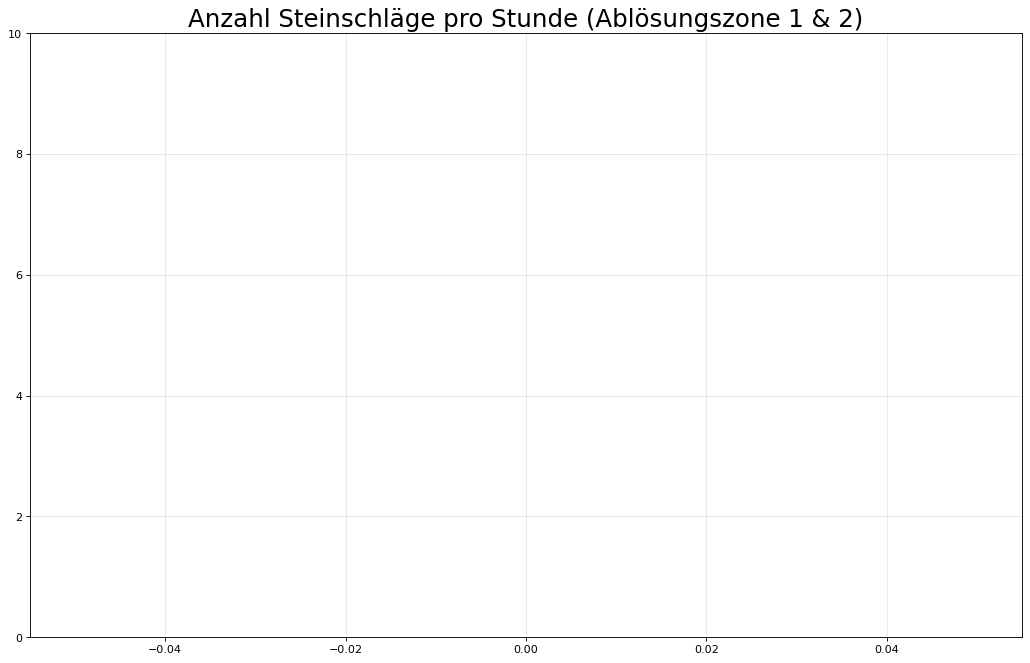

In [45]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(times, rockfalls, color='tab:red')

plt.ylim(0, 10)
plt.title("Anzahl Steinschläge pro Stunde (Ablösungszone 1 & 2)", fontsize=22)
plt.grid(axis='both', alpha=.3) 
plt.show()

In [46]:
# Durchschnittliche Anzahl Steinschläge pro Stunde darstellen
def timelist():
    
    time_list = []
    
    for i in df1["Uhrzeit"]:
        time_list.append(i)
        
    time_list.sort()
                
    return {i: time_list.count(i) for i in time_list}

rockfalls1 = []
times1 = []

for t, r in timelist().items():
    times1.append(t)
    rockfalls1.append(r)

KeyError: 'Uhrzeit'

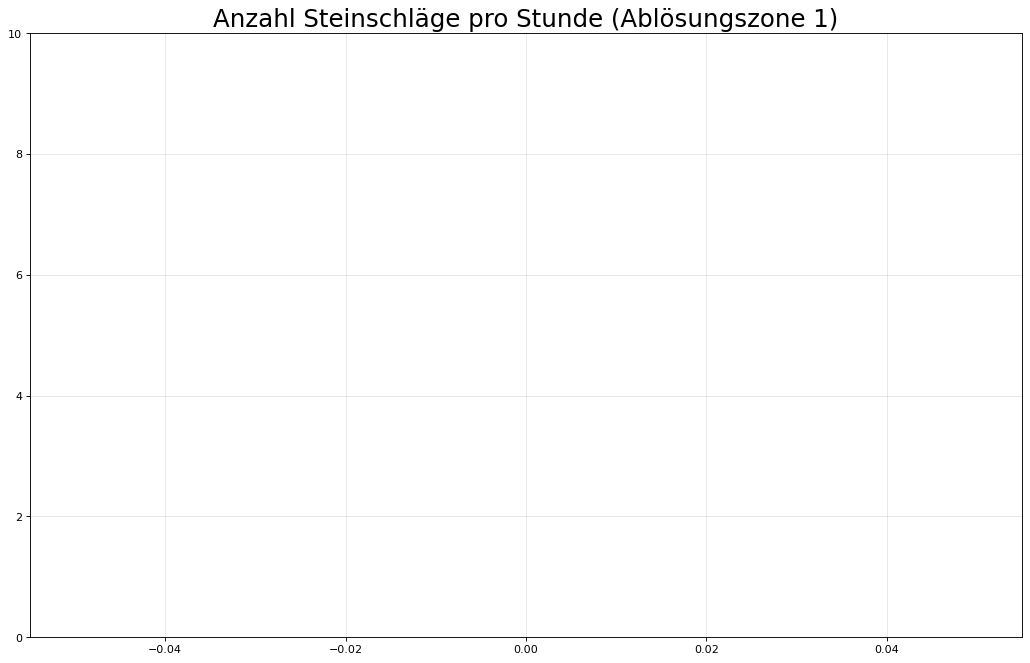

In [47]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(times1, rockfalls1, color='tab:red')

plt.ylim(0, 10)
plt.title("Anzahl Steinschläge pro Stunde (Ablösungszone 1)", fontsize=22)
plt.grid(axis='both', alpha=.3) 
plt.show()

In [48]:
# Durchschnittliche Anzahl Steinschläge pro Stunde darstellen
def timelist():
    
    time_list = []
    
    for i in df2["Uhrzeit"]:
        time_list.append(i)
        
    time_list.sort()
                
    return {i: time_list.count(i) for i in time_list}

rockfalls2 = []
times2 = []

for t, r in timelist().items():
    times2.append(t)
    rockfalls2.append(r)

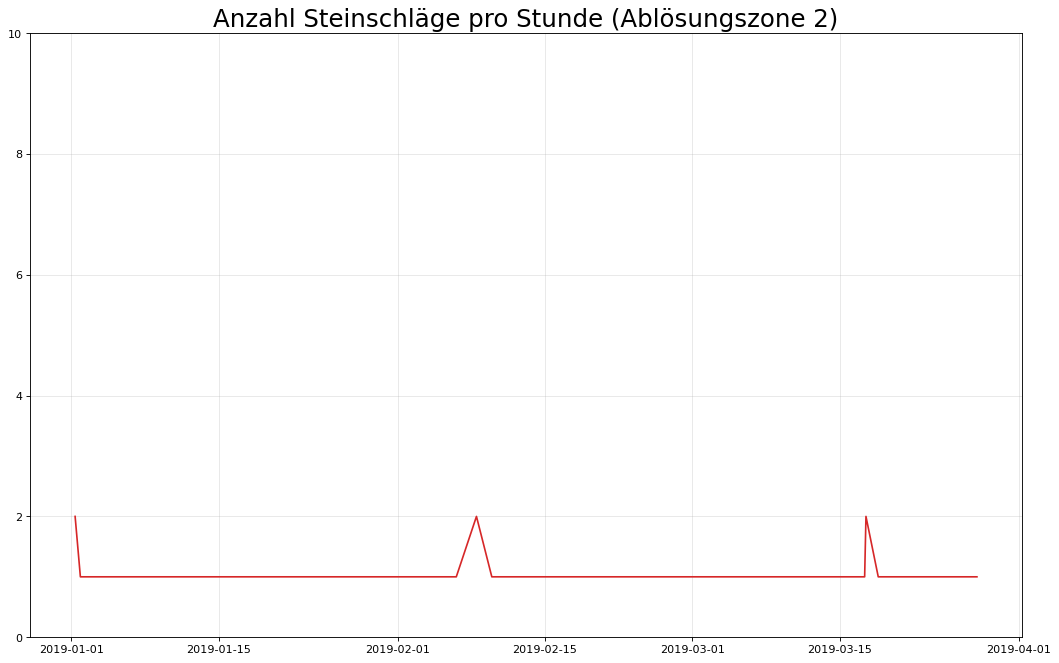

In [49]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(times2, rockfalls2, color='tab:red')

plt.ylim(0, 10)
plt.title("Anzahl Steinschläge pro Stunde (Ablösungszone 2)", fontsize=22)
plt.grid(axis='both', alpha=.3) 
plt.show()

## 10. Netzkapazität
Zwei verschiedenen Netze

Netz Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).

In [ ]:
Energiespalte = df3.loc[:, ["Energie [kJ]"]]
Energiespalte

#Nach Tag Gruppieren, und summe der Masse im Netz finden. 
#An wie vielen Tagen, hatte das Netz 2000 kg Steine? 
#Was passiert wenn das Netz reist? 
#Wahrscheinlichkeit, dass im Netz 2000 kg sind, gesehen ueber Messzeit. 
#Wahrscheinlickeitm, dass ein Stein mit 500 kj herunterfiel.
#Wann werden die Netze geleert. 

Nach Tag Gruppieren, und summe der Masse im Netz finden.

In [59]:
def getList(data):
    l = []
    for i in data:
        l.append(i)
        
    return l

In [91]:
# Nach Datum sortieren
df3 = df3.sort_values("Datum")

list_time = getList(df3["Datum"])
list_mass = getList(df3["Masse [kg]"])



KeyError: 'month'